In [122]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw
import numpy as np
import scipy as sp
from numpy.random import rand
import matplotlib.pyplot as plt
import time
import scipy.linalg as la
from math import prod
from functools import cache, lru_cache
import pickle


In [123]:
#a=4.0232/2
a=1
N=1
s=1
m=1
A=1
J=N*m
MHz = 1e6
kHz = 1e3
us = 1e-6
T = N/(A*m)
mu0 = 4*np.pi*1e-7 * (N/A**2)
hbar = 1.054571817 * 1e-34 * (J*s)
gammaF = 2*np.pi * 40.078 * (MHz/T) # spin 1/2
gammaE = 2*np.pi * 28024.9514242 * (MHz/T) # spin 1/2 
gammaLi = 2*np.pi * 16.546 * (MHz/T) # spin 3/2

# coupling strengths in Hz * A**3
Jf = (hbar/(2*np.pi)) * (mu0/ (4*np.pi)) * gammaF**2 * (10**10)**3
Jlif = (hbar/(2*np.pi)) * (mu0/ (4*np.pi)) * gammaLi*gammaF * (10**10)**3

In [124]:

def flatten(xsss):
    return [x for xss in xsss for xs in xss for x in xs]

def f_coupling_3d(posi, posj, B=(0,0,1)):
    #
    # compute the coupling matrix element of two fluorine spins
    # relative to a large external B field, in a 3d lattice
    #
    if posi == posj:
        return 0
    if type(posi) is int:
        posi = f_atom_pos[posi]
    if type(posj) is int:
        posj = f_atom_pos[posj]
        
    r = (np.array(posi)-np.array(posj))
    d = la.norm(r)
    if d < 1e-8:
        return 0

    bdir = np.array(B) / la.norm(np.array(B))
    cos = (r @ bdir) / d
    return Jf * (1-3*cos**2) / d**3


def expected_nodes(r0):
    return 4*r0**3+6*r0**2+3*r0+1

In [125]:
def grid_graph_2d(L):
    r"""
    Returns a 2d square lattice where each noce is labeled by a spatial
    location, stored as a tuple of integers, (a,b)
    """
    G = rx.PyGraph()
    G.add_nodes_from([(i,j) for j in range(L) for i in range(L)])
    G.add_edges_from([(i+j*L,i+1+j*L,None) for j in range(L) for i in range(L-1)])
    G.add_edges_from([(i+j*L,i+(j+1)*L,None) for j in range(L-1) for i in range(L)])
    return G

def grid_graph_3d(L):
    r"""
    Returns a 3d square lattice where each noce is labeled by a spatial
    location, stored as a tuple of integers, (a,b,c). Only neartest neighbor bonds are included
    """
    G = rx.PyGraph()
    G.add_nodes_from([(i,j,k) for k in range(L) for j in range(L) for i in range(L)])
    G.add_edges_from([(i+j*L+k*L**2,(i+1)+j*L+k*L**2,None) for k in range(L) for j in range(L) for i in range(L-1)])
    G.add_edges_from([(i+j*L+k*L**2,(i)+(j+1)*L+k*L**2,None) for k in range(L) for j in range(L-1) for i in range(L)])
    G.add_edges_from([(i+j*L+k*L**2,(i)+j*L+(k+1)*L**2,None) for k in range(L-1) for j in range(L) for i in range(L)])
    return G

def square_grid_graph(L,dim=2):
    r"""
    Generate a square graph in dimension d with side length L
    """
    G=rx.generators.path_graph(L)
    Gnew=rx.generators.path_graph(L)
    for _ in range(dim-1):
        G, hold = rx.cartesian_product(Gnew,G)
    return G

In [126]:
nn_adjacency = [np.array([alpha*a, beta*a,0]) for alpha in (-1,1) for beta in (-1,1)]
nn_adjacency += [np.array([alpha*a,0,beta*a]) for alpha in (-1,1) for beta in (-1,1)]
nn_adjacency += [np.array([0,alpha*a,beta*a]) for alpha in (-1,1) for beta in (-1,1)]

def generate_fcc(r0):
    r"""
    Generates an FCC lattice of Manhattan radius r0 as a graph structure
    edges currently denote nearest neighbor coupling and have no data payload
    generating this graph can be quite slow for large systems due to mandatory for
    loops which make me want to cry
    
    future iterations should include next-nearest neighbors, and include the bond strength as a data payload
    """
    odds=list(range(-r0,r0+1,2))
    evens=list(range(-r0+1,r0+1,2))
    f_atom_pos = flatten([[[np.array([i*a,j*a,k*a]) for i in odds] for j in odds] for k in odds]) + flatten([[[np.array([i*a,j*a,k*a]) for i in evens] for j in evens] for k in odds])
    f_atom_pos += flatten([[[np.array([i*a,j*a,k*a]) for i in evens] for j in odds] for k in evens]) + flatten([[[np.array([i*a,j*a,k*a]) for i in odds] for j in evens] for k in evens])
        
    G=rx.PyGraph(multigraph=False)
    node_indices = G.add_nodes_from(f_atom_pos)
    
    for idxA in node_indices:
        source = G.get_node_data(idxA)
        counter=0
        for idxB in node_indices:
            target = G.get_node_data(idxB)
            if np.any(np.all(nn_adjacency == source-target, axis=1)):
                G.add_edge(idxA,idxB,None)
                counter += 1
                if counter == len(nn_adjacency):
                    break
                
    return G

@cache
def get_fcc_graph(r,fmt='fcc_'):
    r"""
    Attempts to load an fcc graph from the local directory
    If it can't find it, we regenerate. By default, we look for strings
    which are named "fcc_{r}.dat", but you can set the text before the
    inf-norm radius via `fmt`.
    """
    try:
        G = pickle.load(open(f"{fmt}{r}.dat", "rb"))
    except (OSError,IOError) as e:
        G = generate_fcc(r)
        with open(f'{fmt}{r}.dat','wb') as fi:
            pickle.dump(G,fi)
    return G

@cache
def grid_graph(dim,fmt='sc_'):
    r"""
    Generate a dense graph of dimension len(dim) with side lengths
    define by the tuple `dim`
    
    This graphs are not labeled with spatial coordinates
    """
    try:
        G = pickle.load(open(f"{fmt}{dim}.dat","rb"))
    except (OSError,IOError) as e:
        if len(dim) == 1:
            return rx.generators.path_graph(dim[0])
        #elif len(dim) == 2:
        #    return rx.cartesian_product(
        #        rx.generators.path_graph(dim[0]),
        #        rx.generators.path_graph(dim[1])
        #    )
        else:
            G=rx.generators.path_graph(dim[0])
            for idx in range(1,len(dim)):
                Gnew=rx.generators.path_graph(dim[idx])
                G, _ = rx.cartesian_product(Gnew,G)
                
        with open(f'{fmt}{dim}.date','wb') as fi:
            pickle.dump(G,fi)
    return G

In [131]:
def _OLD_generate_percolation_graph(p,dim):
    r"""
    generate a percolation graph with bond acceptance probability p
    `dim` should be a tuple containing the dimension of the graph,
    e.g (L,) or (L,L)
    """
    if dim in dense_grids:
        G = dense_grids[dim].copy()
    else:
        G = grid_graph(dim)
        dense_grids[dim] = G.copy()
    
    temp = [edge if p < rand() else -1 for edge in G.edge_list()]
    remove_list = [x for x in temp if x != -1] if -1 in temp else temp
    G.remove_edges_from(remove_list)
    return G

def generate_percolation_graph(p,generator,dim):
    r"""
    Generates a percolation graph with bond acceptance probability p,
    with the dense graph being defined by the function `generator`. This
    function will be called with the `dim` keyword. That seems like silly
    design? Maybe? The idea is that the structure is defined by `generator`,
    and the size of the structure is defined by `dim`. Obviously, `dim` and
    `generator` need to play nicely together so this maybe isn't very 
    end-user friendly.
    """
    G = generator(dim).copy()
    marked_edges = [edge if p < rand() else -1 for edge in G.edge_list()]
    remove_list = [x for x in marked_edges if x != -1] if -1 in marked_edges else marked_edges
    G.remove_edges_from(remove_list)
    return G

def avg_cluster_size(p, dim, generator=grid_graph, repititions=100):
    r"""
    For a square graph of L*L nodes, compute the average cluster size,
    excluding the largest cluster. As L->infinity, this ensures that this
    function diverges at the phase transition, but nowhere else.
    """
    try:
        G0 = generator(dim)
    except Exception as e:
        print("generator and dim are mismatched")
        return
    sites = G0.num_nodes()
    counts = np.zeros(sites+1,dtype=np.int64)
    for _ in range(repititions):
        G = generate_percolation_graph(p,generator,dim)
        comps = rx.connected_components(G)
        distro = [len(comp) for comp in comps]
        largest_local = np.max(distro)
        temp_counts = np.bincount([len(comp) for comp in comps],minlength=sites+1)
        temp_counts[largest_local]=0
        counts += temp_counts
    bins = np.array(range(sites+1))    
    return (bins**2 @ counts) / (bins@counts)

def percolation_strength(p,dim,generator=grid_graph,repititions=100):
    r"""
    For a square graph of L*L nodes, compute the percolation strength,
    which is the proportion of the graph belonging to the largest cluster,
    which should be the order paramater of the phase tranistion as L->infinity
    """
    P = 0
    try:
        G0 = generator(dim)
    except Exception as e:
        print("generator and dim are mismatched")
        return
    sites = G0.num_nodes()
    for _ in range(repititions):
        G = generate_percolation_graph(p,generator,dim)
        distro = [len(comp) for comp in rx.connected_components(G)]
        largest_local = np.max(distro)
        P += largest_local / sites
    return P/repititions

def cluster_size_and_strength(p,dim,generator=grid_graph,repititions=100):
    r"""
    return both the percolation strength and the average cluster size
    for the square L*L percolation graph as a tuple (size, strength)
    """
    try:
        G0 = generator(dim)
    except Exception as e:
        print("generator and dim are mismatched")
        return
    sites = G0.num_nodes()
    counts = np.zeros(sites+1,dtype=np.int64)
    P = 0
    for _ in range(repititions):
        G = generate_percolation_graph(p,generator,dim)
        distro = [len(comp) for comp in rx.connected_components(G)]
        largest_local = np.max(distro)
        P += largest_local / sites
        temp_counts = np.bincount([len(comp) for comp in rx.connected_components(G)],minlength=sites+1)
        temp_counts[largest_local]=0
        counts += temp_counts
    bins = np.array(range(sites+1))    
    return (bins**2 @ counts) / (bins@counts), P

In [155]:
r_list = [6,8,10,12]
pvals = np.arange(.05,.35,.01)

reps=100
density = {}
strength = {}
for r in r_list:
    start = time.time()
    density[r] = [avg_cluster_size(p,r,generator=get_fcc_graph,repititions=reps) for p in pvals]
    strength[r] = [percolation_strength(p,r,generator=get_fcc_graph,repititions=reps) for p in pvals]
    end = time.time()
    print(f"Avg Computation time per fcc graph for r={r} is {(end-start)/(reps*len(pvals))} s")

Avg Computation time per fcc graph for r=6 is 0.007334620873133342 s
Avg Computation time per fcc graph for r=8 is 0.017043627977371217 s
Avg Computation time per fcc graph for r=10 is 0.034348076025644936 s
Avg Computation time per fcc graph for r=12 is 0.05678582827250163 s


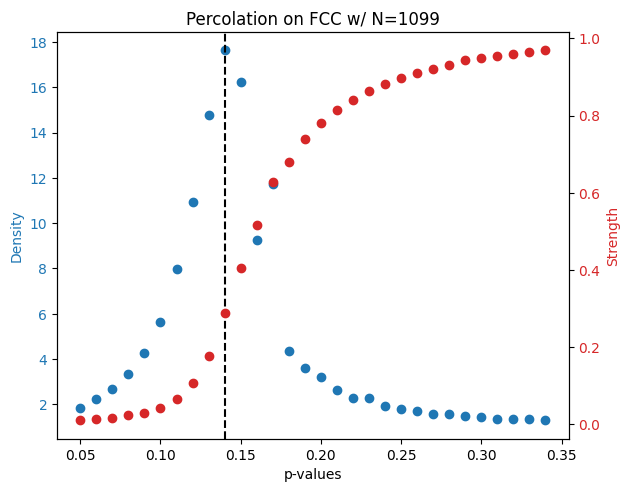

In [142]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('p-values')
ax1.set_ylabel('Density', color=color)
ax1.scatter(pvals, density[6], label="density", color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Strength', color=color)  # we already handled the x-label with ax1
ax2.scatter(pvals, strength[6], label="strength", color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Find the p-value corresponding to the maximum density
max_density_pval = pvals[np.argmax(density[6])]

# Add a vertical dashed line at the maximum density value
ax1.axvline(x=max_density_pval, color='black', linestyle='--')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f"Percolation on FCC w/ N={expected_nodes(6)}")
plt.show()

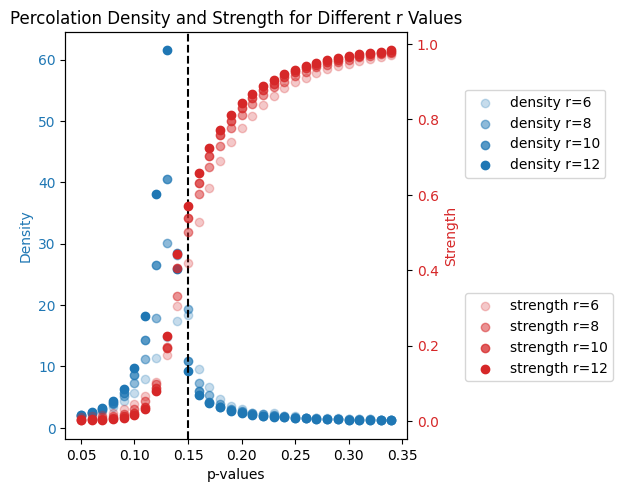

In [ ]:
fig, ax1 = plt.subplots()
max_density_pval=0
max_density=0
color = 'tab:blue'
ax1.set_xlabel('p-values')
ax1.set_ylabel('Density', color=color)
for idx, r in enumerate(r_list):
    ax1.scatter(pvals, density[r], label=f"density r={r}", color=color,alpha=(idx+1)/len(r_list))
    ax1.tick_params(axis='y', labelcolor=color)
    if max_density < np.max(density[r]):
        max_density_pval=pvals[np.argmax(density[r])]
        max_density = np.max(density[r])
    
    
ax1.axvline(x=max_density_pval, color='black', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.75))


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Strength', color=color)  # we already handled the x-label with ax1
for idx, r in enumerate(r_list):
    ax2.scatter(pvals, strength[r], label=f"strength r={r}", color=color,alpha=(idx+1)/len(r_list))
    ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Percolation Density and Strength for Different r Values")
plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.25))
plt.show()